# HAZMAT MODELLO UNIFICATO

In [1]:
import gurobipy as gp
from gurobipy import GRB
import math
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# CONFIGURAZIONE STRATEGICA (LEVE DI COMANDO)

In [2]:
ALPHA = 0 # Sicurezza (da 0 a 1)

# SCENARIO
NUM_NODI = 50       # Numero di incroci nella città
NUM_CENTRI = 5      # Numero di scuole/ospedali
ETA = 150.0         # Raggio di sicurezza (metri) - Soglia di pericolo

print(f"--- AVVIO SIMULAZIONE (M2/M3/M4) ---")
print(f"Modalità scelta: ALPHA={ALPHA}")
print(f"Scenario: {NUM_NODI} nodi, {NUM_CENTRI} centri, Eta={ETA}m")

--- AVVIO SIMULAZIONE (M2/M3/M4) ---
Modalità scelta: ALPHA=0
Scenario: 50 nodi, 5 centri, Eta=150.0m


# 1. GENERAZIONE DATI (Creazione Città)

In [3]:
# Definizione percorso
ORIGIN = 0
DESTINATION = NUM_NODI - 1

# Seed fisso per la tesi
random.seed(5) 

# 1. Generazione delle coordinate base per tutti i nodi
coords = {i: (random.uniform(0, 1000), random.uniform(0, 1000)) for i in range(NUM_NODI)}

# 2. METODO DELLE ZONE DI ESCLUSIONE:
# Ora che ORIGIN e DESTINATION sono definiti sopra, il codice funzionerà
coords[ORIGIN] = (50.0, 50.0)        # In basso a sinistra
coords[DESTINATION] = (800.0, 800.0)  # In alto a destra
# 3. Creazione Archi (Strade locali)
arcs = []
dist_matrix = {} 
for i in range(NUM_NODI):
    for j in range(NUM_NODI):
        if i != j:
            d = math.sqrt((coords[i][0]-coords[j][0])**2 + (coords[i][1]-coords[j][1])**2)
            if d < 250: # Distanza di connessione aumentata per garantire il percorso
                arcs.append((i, j))
                dist_matrix[i, j] = d

# 4. GENERAZIONE CENTRI VULNERABILI (Fascia Centrale 250-750)
vulnerable_centers = {}
for k in range(NUM_CENTRI):
    vulnerable_centers[f"P{k}"] = {
        'coords': (random.uniform(200, 800), random.uniform(250, 750)), 
        'pop': random.randint(500, 2000)
    }

print(f"--- DATI GENERATI CORRETTAMENTE ---")
print(f"Rete: {NUM_NODI} nodi e {len(arcs)} archi.")
print(f"Origine (Nodo {ORIGIN}): {coords[ORIGIN]}")
print(f"Destinazione (Nodo {DESTINATION}): {coords[DESTINATION]}")

--- DATI GENERATI CORRETTAMENTE ---
Rete: 50 nodi e 324 archi.
Origine (Nodo 0): (50.0, 50.0)
Destinazione (Nodo 49): (800.0, 800.0)


# 2. PREPROCESSING GEOMETRICO (Calcolo Parametri)

In [4]:
def get_segment_distance(px, py, x1, y1, x2, y2):
    # Calcola distanza minima punto-segmento
    l2 = (x1-x2)**2 + (y1-y2)**2
    if l2 == 0: return math.sqrt((px-x1)**2 + (py-y1)**2)
    t = ((px-x1)*(x2-x1) + (py-y1)*(y2-y1)) / l2
    t = max(0, min(1, t))
    proj_x = x1 + t*(x2-x1)
    proj_y = y1 + t*(y2-y1)
    return math.sqrt((px-proj_x)**2 + (py-proj_y)**2)

# Popolamento dizionario distanze (SOLO se <= ETA)
d_ij_p_param = {}
for (i, j) in arcs:
    x1, y1 = coords[i]
    x2, y2 = coords[j]
    for p_id, data in vulnerable_centers.items():
        dist = get_segment_distance(data['coords'][0], data['coords'][1], x1, y1, x2, y2)
        if dist <= ETA:
            d_ij_p_param[i, j, p_id] = dist

print(f"Dati Generati. Parametri di rischio calcolati: {len(d_ij_p_param)}")

Dati Generati. Parametri di rischio calcolati: 102


# 3. IL MODELLO UNIFICATO

In [5]:
model = gp.Model("Hazmat_Unified")

# --- Variabili Decisionali ---
x = model.addVars(arcs, vtype=GRB.BINARY, name="x") # Arco usato (0/1)
z = model.addVars(d_ij_p_param.keys(), vtype=GRB.BINARY, name="z") # Assegnamento arco-centro
z_eta = model.addVars(vulnerable_centers.keys(), vtype=GRB.BINARY, name="z_eta") # Centro 'Sicuro'
w = model.addVar(vtype=GRB.CONTINUOUS, lb=0, name="w") # Variabile Maximin

# --- Funzione Obiettivo Combinata (Logica M3/M4) ---
# Lunghezza Totale del Percorso
route_len = gp.quicksum(x[i, j] * dist_matrix[i, j] for i, j in arcs)

# Fattore di scala per rendere confrontabili km e rischio
SCALE_FACTOR = 1.0 / 2000.0 

# Obiettivo: Massimizza (Alpha * Sicurezza) - ((1-Alpha) * Costo_Scalato)
obj_expr = (ALPHA * w) - ((1 - ALPHA) * route_len * SCALE_FACTOR)
model.setObjective(obj_expr, GRB.MAXIMIZE)

# --- Vincoli (Standard M2) ---

# D_ETA (Popolazione minima per normalizzazione teorica)
min_pop = min(v['pop'] for v in vulnerable_centers.values())
D_ETA = min_pop

# 11. Definizione w (Upper Bound del rischio)
for p in vulnerable_centers:
    expr = gp.LinExpr()
    for (i, j) in arcs:
        if (i, j, p) in d_ij_p_param:
            expr += (d_ij_p_param[i, j, p] / vulnerable_centers[p]['pop']) * z[i, j, p]
    expr += (ETA / D_ETA) * z_eta[p]
    model.addConstr(w <= expr, name=f"Def_w_{p}")

# 12. Unicità (Un centro è assegnato a 1 arco vicino O è sicuro)
for p in vulnerable_centers:
    expr = gp.quicksum(z[i, j, p] for (i, j) in arcs if (i, j, p) in d_ij_p_param)
    model.addConstr(expr + z_eta[p] <= 1, name=f"Unique_{p}")

# 13. Closest Assignment (Assegna sempre all'arco attivo più vicino)
for p in vulnerable_centers:
    for (i, j) in arcs:
        if (i, j, p) in d_ij_p_param:
            curr_dist = d_ij_p_param[i, j, p]
            closer_sum = gp.quicksum(z[k, l, p] for k, l in arcs 
                                     if (k, l, p) in d_ij_p_param and d_ij_p_param[k, l, p] < curr_dist)
            model.addConstr(z[i, j, p] >= x[i, j] - closer_sum, name=f"Closest_{i}_{j}_{p}")

# 14. Link x-z (Coerenza logica)
for (i, j, p) in d_ij_p_param:
    model.addConstr(z[i, j, p] <= x[i, j])

# 16. Force Safe (Se nessun arco vicino è usato, z_eta deve essere 1)
for p in vulnerable_centers:
    expr = gp.quicksum(z[i, j, p] for (i, j) in arcs if (i, j, p) in d_ij_p_param)
    model.addConstr(z_eta[p] >= 1 - expr)

# 17. Flusso (Shortest Path logic: Origine -> Destinazione)
for n in range(NUM_NODI):
    flow_in = gp.quicksum(x[j, n] for j in range(NUM_NODI) if (j, n) in arcs)
    flow_out = gp.quicksum(x[n, j] for j in range(NUM_NODI) if (n, j) in arcs)
    if n == ORIGIN: model.addConstr(flow_out - flow_in == 1)
    elif n == DESTINATION: model.addConstr(flow_out - flow_in == -1)
    else: model.addConstr(flow_out - flow_in == 0)

print("Modello Costruito con successo.")

Set parameter Username
Set parameter LicenseID to value 2717164
Academic license - for non-commercial use only - expires 2026-10-02
Modello Costruito con successo.


# 4. RISOLUZIONE E OUTPUT GRAFICO

--- AVVIO OTTIMIZZAZIONE ---
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 269 rows, 432 columns and 2521 nonzeros
Model fingerprint: 0x6f2870a9
Variable types: 1 continuous, 431 integer (431 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e-02, 1e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -3.3705162
Presolve removed 105 rows and 88 columns
Presolve time: 0.01s
Presolved: 164 rows, 344 columns, 1316 nonzeros
Variable types: 0 continuous, 344 integer (344 binary)

Root relaxation: objective -6.248712e-01, 42 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth Int

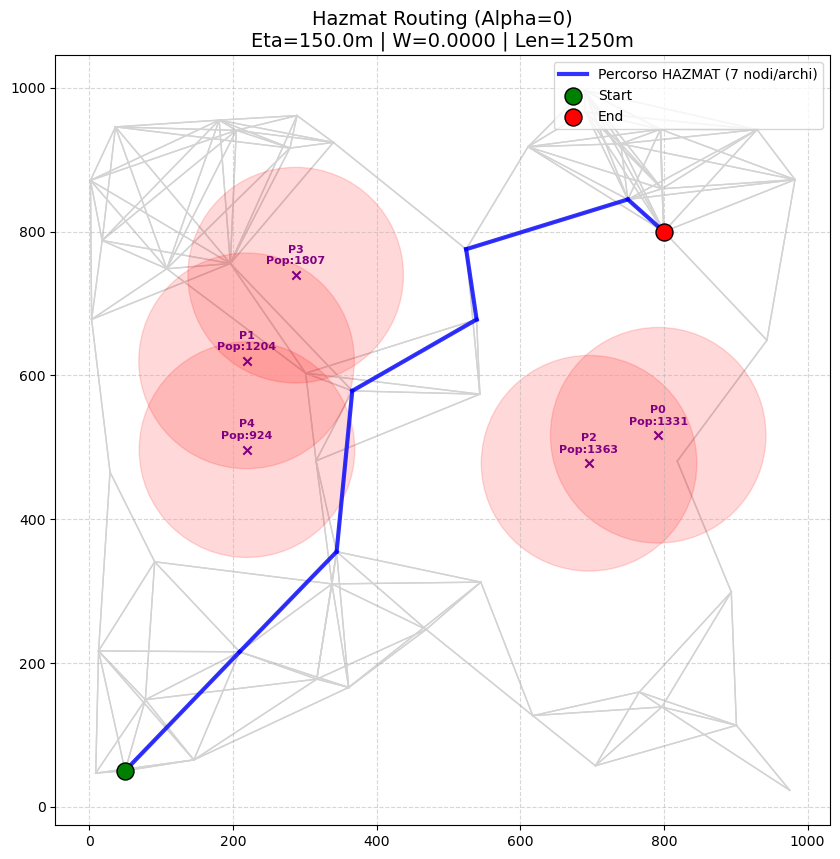

Grafico salvato come 'unified_solution.png'


In [6]:
print("--- AVVIO OTTIMIZZAZIONE ---")
model.optimize()

if model.status == GRB.OPTIMAL:
    final_len = sum(x[i,j].X * dist_matrix[i,j] for i,j in arcs if x[i,j].X > 0.5)
    print(f"\nRISULTATO OTTIMO (Alpha={ALPHA}):")
    print(f" -> Sicurezza W (Maximin): {w.X:.6f}")
    print(f" -> Lunghezza Percorso: {final_len:.2f} metri")
    
    # --- PLOT GRAFICO ---
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Disegna tutti gli archi (sfondo grigio)
    for i, j in arcs:
        ax.plot([coords[i][0], coords[j][0]], [coords[i][1], coords[j][1]], c='lightgray', lw=1, zorder=1)
    
    # Disegna il percorso ottimo (blu)
    # Contiamo quanti archi sono stati scelti
    num_archi_scelti = sum(1 for i, j in arcs if x[i, j].X > 0.5)
    
    legend_added = False # Flag per aggiungere l'etichetta solo una volta
    
    for i, j in arcs:
        if x[i, j].X > 0.5:
            # Creiamo l'etichetta solo per il primo arco disegnato
            if not legend_added:
                label_percorso = f"Percorso HAZMAT ({num_archi_scelti} nodi/archi)"
                legend_added = True
            else:
                label_percorso = "" # Per gli altri archi non scriviamo nulla
            
            x_vals = [coords[i][0], coords[j][0]]
            y_vals = [coords[i][1], coords[j][1]]
            ax.plot(x_vals, y_vals, c='blue', lw=3, label=label_percorso, zorder=4, alpha=0.8)

    # Disegna i Centri Vulnerabili e le zone ETA
    for p_id, data in vulnerable_centers.items():
        cx, cy = data['coords']
        # Cerchio rosso (zona di pericolo Eta)
        ax.add_patch(patches.Circle((cx, cy), ETA, color='red', alpha=0.15))
        # Centro esatto (X viola)
        ax.scatter([cx], [cy], c='purple', marker='x', zorder=5)
        ax.text(cx, cy+15, f"{p_id}\nPop:{data['pop']}", color='purple', ha='center', fontsize=8, fontweight='bold')

    # Origine e Destinazione
    ax.scatter(*coords[ORIGIN], c='green', s=150, label='Start', zorder=6, edgecolors='black')
    ax.scatter(*coords[DESTINATION], c='red', s=150, label='End', zorder=6, edgecolors='black')
    
    # Titolo e dettagli
    ax.set_title(f"Hazmat Routing (Alpha={ALPHA})\nEta={ETA}m | W={w.X:.4f} | Len={final_len:.0f}m", fontsize=14)
    ax.legend(loc='upper right')
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # Salva e mostra
    plt.savefig("unified_solution.png")
    plt.show()
    print("Grafico salvato come 'unified_solution.png'")
else:
    print("Nessuna soluzione trovata (Infeasible). Prova ad aumentare il numero di nodi o la distanza di connessione.")